In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Step 1: Read and analyze the data
data = pd.read_csv('toyota.csv')
print("Initial Data:")
print(data.head())
print("\nData Info:")
data.info()

Initial Data:
   Price  Age  Mfg_Month  Mfg_Year     KM Fuel_Type  HP  Met_Color  Automatic  \
0  12950   23         10      2002  46986    Diesel  90          1          0   
1  12950   23         10      2002  72937    Diesel  90          1          0   
2  12950   24          9      2002  41711    Diesel  90          1          0   
3  13950   26          7      2002  48000    Diesel  90          0          0   
4  17950   30          3      2002  38500    Diesel  90          0          0   

     cc  Doors Gears  Quarterly_Tax  Weight  Mfr_Guarantee  BOVAG_Guarantee  \
0  2000    3.0  Five            210    1165            0.0                1   
1  2000    3.0  Five            210    1165            0.0                1   
2  2000    3.0  Five            210    1165            1.0                1   
3  2000    3.0  Five            210    1165            1.0                1   
4  2000    3.0  Five            210    1170            1.0                1   

   Guarantee_Period  
0 

In [9]:
# Encode categorical columns
categorical_columns = ['Fuel_Type', 'Gears']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Step 2: Split the dataset into train and test sets
X = data.drop(columns=['Price'])  # 'Price' is the target column
y = data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Step 3: Check the shape of training and test sets
print("\nShape of Training Set:", X_train.shape)
print("Shape of Test Set:", X_test.shape)


Shape of Training Set: (40, 16)
Shape of Test Set: (10, 16)


In [11]:
# Step 4: Perform scaling in the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Step 5: Calculate the % of missing values in each column
missing_percentages = data.isnull().mean() * 100
print("\nPercentage of Missing Values:")
print(missing_percentages)


Percentage of Missing Values:
Price                0.0
Age                  0.0
Mfg_Month            0.0
Mfg_Year             0.0
KM                   0.0
Fuel_Type            0.0
HP                   0.0
Met_Color            0.0
Automatic            0.0
cc                   0.0
Doors               12.0
Gears                0.0
Quarterly_Tax        0.0
Weight               0.0
Mfr_Guarantee       46.0
BOVAG_Guarantee      0.0
Guarantee_Period     0.0
dtype: float64


In [13]:
# Step 6: Remove features with missing values > 20%
data = data.loc[:, missing_percentages <= 20]

In [16]:
# Step 7: Impute missing values for columns with < 20% missing
def impute_missing_values(df, strategy='mean'):
    imputer = SimpleImputer(strategy=strategy)
    for column in df.columns:
        if df[column].isnull().any():
            df.loc[:, column] = imputer.fit_transform(df[[column]])
    return df

data = impute_missing_values(data, strategy='mean')

In [15]:
# Step 8: Remove outliers (Z-score method)
from scipy.stats import zscore
z_scores = np.abs(zscore(data.select_dtypes(include=[np.number])))
data = data[(z_scores < 3).all(axis=1)]

In [19]:
# Step 9: Find constant features using VarianceThreshold
selector = VarianceThreshold(threshold=0.0)
try:
    selector.fit(data)
    constant_features = [column for column in data.columns if column not in data.columns[selector.get_support()]]
    print("\nConstant Features:", constant_features)
except ValueError as e:
    print(f"Error: {e}")

Error: Found array with 0 sample(s) (shape=(0, 16)) while a minimum of 1 is required by VarianceThreshold.


In [22]:
# Step 10: Remove features with low variance
if not data.empty:
    selector = VarianceThreshold(threshold=0.01)
    selector.fit(data)
    data = data[data.columns[selector.get_support()]]
else:
    print("DataFrame is empty. Skipping VarianceThreshold.")

DataFrame is empty. Skipping VarianceThreshold.


In [21]:
# Step 11: Remove highly correlated features
correlation_matrix = data.corr()
high_correlation = correlation_matrix.abs() > 0.9
upper_triangle = np.triu(high_correlation, k=1)
features_to_remove = [column for column in correlation_matrix.columns if any(upper_triangle[:, list(correlation_matrix.columns).index(column)])]
data = data.drop(columns=features_to_remove)

In [29]:
# Step 12: Perform Univariate feature selection
from sklearn.impute import SimpleImputer

# Impute missing values in X_train and X_test
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Perform scaling after imputation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Univariate feature selection
k_best_selector = SelectKBest(score_func=f_classif, k=10)
k_best_selector.fit(X_train_scaled, y_train)
selected_features = X.columns[k_best_selector.get_support()]
print("\nSelected Features (Univariate Selection):", selected_features)


Selected Features (Univariate Selection): Index(['Age', 'Mfg_Month', 'KM', 'Fuel_Type', 'HP', 'cc', 'Doors', 'Gears',
       'Quarterly_Tax', 'Weight'],
      dtype='object')


/home/codespace/.local/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [2] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/home/codespace/.local/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/codespace/.local/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


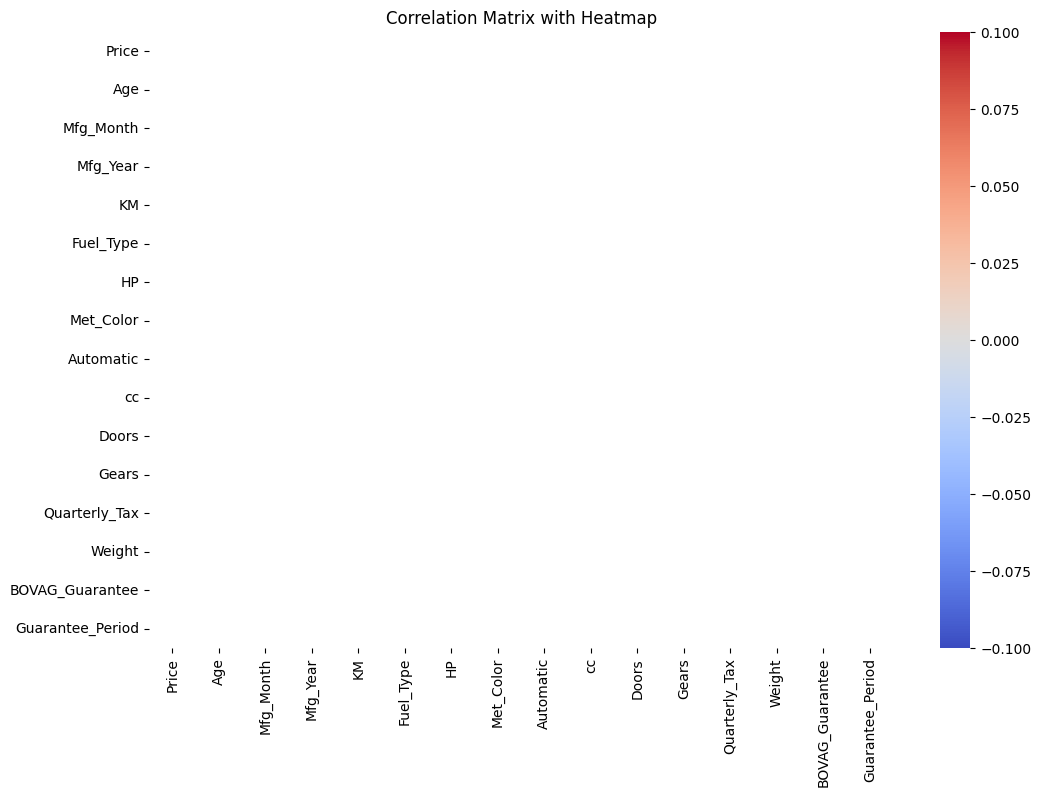

In [26]:
# Step 13: Correlation Matrix and Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Matrix with Heatmap")
plt.show()


In [30]:
# Step 14: Apply PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print("\nPCA Explained Variance Ratio:", pca.explained_variance_ratio_)


PCA Explained Variance Ratio: [0.29541033 0.17598464]


In [31]:
# Step 15: Apply LDA
lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)
print("\nLDA Coefficients:", lda.coef_)


LDA Coefficients: [[-1.98887420e+02  1.98887420e+02  3.04298517e-13  4.01275057e+01
   3.64631395e+02 -1.27180543e+02  1.39320416e+01  1.62678915e+01
   2.34144246e+02  3.30793360e+01  6.73198655e+01  9.74660446e+01
  -6.88131546e+01  3.12883476e+01 -1.07220012e+01  3.48690777e+00]
 [-2.43868792e+02  2.43868792e+02  1.82981529e-13  5.86747935e+01
   2.25661843e+02 -6.47534531e+01  2.68493274e+01  3.31832872e+01
   1.74276906e+02  5.94168508e+01  6.71486202e+01  3.93608971e+01
  -1.06586333e+02  4.60440457e+01 -1.15107713e+01  1.64021300e+01]
 [-2.07530226e+02  2.07530226e+02  3.87720310e-13  4.78924807e+01
   4.51667171e+02 -1.50787298e+02  7.53784570e+00  1.32205082e+01
   2.61045092e+02  3.04223765e+01  7.39673597e+01  1.44489954e+02
  -6.92884220e+01  3.35067541e+01 -1.48947927e+01 -1.55674811e+00]
 [-2.03485349e+02  2.03485349e+02  2.69309402e-13  4.33597999e+01
   3.20743955e+02 -1.05344385e+02  1.14946091e+01  1.57368526e+01
   2.01865385e+02  2.01294388e+01  6.08776464e+01  8.7